In [ ]:
!pip install requests
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install collections
!pip install string
!pip install tensorflow
!pip install tensorflow
!pip install sklearn

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = '1TPg1QMmtzptOOID6wtglmkTSjWegU1lf'
destination = '/content/training_checkpoints.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1a84skAcQXaAMXxIquu5KgYIPLK2p2jXX'
destination = '/content/dataset.tsv'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '10e7aToeaDuk7L7g7_YZtvwAj-496scs2'
destination = '/content/test.csv'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip training_checkpoints.zip

Archive:  training_checkpoints.zip
   creating: training_checkpoints/
  inflating: training_checkpoints/checkpoint  
  inflating: training_checkpoints/ckpt-11.data-00000-of-00001  
  inflating: training_checkpoints/ckpt-11.index  


In [ ]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*4

In [ ]:
data_df = pd.read_csv("dataset.tsv", sep='\t')#read dataset
data_df.rename(columns={ data_df.columns[0]: "english_sentence" }, inplace = True)#rename the column
data_df.rename(columns={ data_df.columns[1]: "hindi_sentence" }, inplace = True)#rename the column
mask_df = (data_df['english_sentence'].str.len()>20) & (data_df['english_sentence'].str.len()<200)
data_df = data_df.loc[mask_df]
data_df = data_df.sample(50000, random_state=1)
data_df = data_df.dropna()
data_df.head()

,english_sentence,hindi_sentence
10235,The two Prime Ministers agreed that the only w...,दोनों प्रधानमंत्रियों ने इस बात पर भी सहमति जत...
48352,"Apart from this, some funds are provided – bot...",इसके अलावा कुछ राशि – राजस्‍व एवं पूंजीगत दोनो...
51442,“Kader Khan Ji brightened the screen with his ...,प्रधानमंत्री ने अपने शोक संदेश में कहा ‘कादर ख...
1370,“The future belongs to social media.,”भविष्‍य सोशल मीडिया का होगा।
48902,"He also recalled that on Republic Day, the ent...",उन्‍होंने गणतंत्र दिवस को याद करते हुए कहा कि ...


In [ ]:
data_df.count()

english_sentence    50000
hindi_sentence      50000
dtype: int64

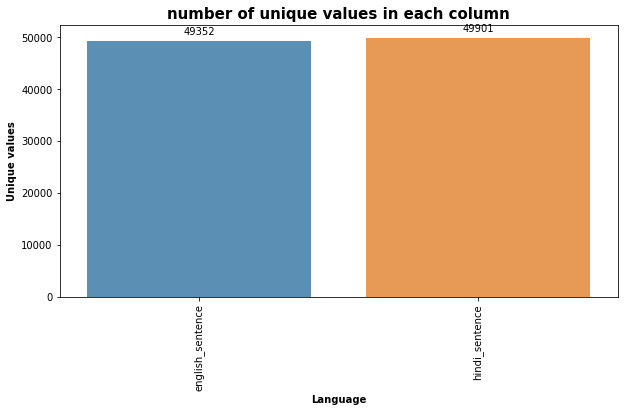

In [ ]:
unique_df = pd.DataFrame()
unique_df['Features'] = data_df.columns
unique=[]
for i in data_df.columns:
    unique.append(data_df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(10,5))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('number of unique values in each column',weight='bold', size=15)
plt.ylabel('Unique values', size=10, weight='bold')
plt.xlabel('Language', size=10, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.drop(['source'],axis=1,inplace=True)
test_df.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


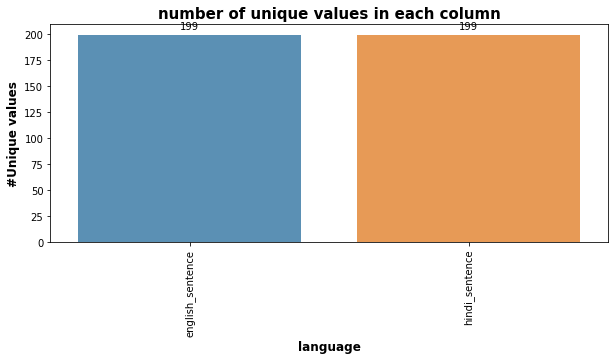

In [ ]:
unique_df = pd.DataFrame()
unique_df['Features'] = test_df.columns
unique=[]
for i in test_df.columns:
    unique.append(test_df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(10,4))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('language', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
eng_df = data_df['english_sentence']
hind_df = data_df['hindi_sentence']
test_eng_df = test_df['english_sentence']
test_hind_df = test_df['english_sentence']
eng_df = eng_df.apply(lambda x: "<SOS> " + str(x) + " <EOS>")#apply tokens at starting and ending of every eng sentence
hind_df = hind_df.apply(lambda x: "<SOS> "+ x + " <EOS>")#apply tokens at starting and ending of every hindi sentence
test_eng_df = test_eng_df.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
test_hind_df = test_hind_df.apply(lambda x: "<SOS> "+ x + " <EOS>")

In [ ]:
#removing special characters and symbols
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'#remove special characters and symbols like #$%&()*+,-./:;=?@[\\]^_`{|}~
oov_token = '<unk>'# 'UNK' indicates unknown word for showing that where is the missing word
## Tokenize the sentences
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)#apply tokenize for eng sentence
hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)#apply tokenize for hindi sentence
test_eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)#apply tokenize for eng sentence
test_hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng_df)#Updates internal vocabulary based on a list of texts.
hind_tokenizer.fit_on_texts(hind_df)
test_eng_tokenizer.fit_on_texts(test_eng_df)#Updates internal vocabulary based on a list of texts.
test_hind_tokenizer.fit_on_texts(test_hind_df)
inputs = eng_tokenizer.texts_to_sequences(eng_df)#Transforms each english text in texts to a sequence of integers.
targets = hind_tokenizer.texts_to_sequences(hind_df)#Transforms each hindi text in texts to a sequence of integers
test_inputs = test_eng_tokenizer.texts_to_sequences(test_eng_df)#Transforms each english text in texts to a sequence of integers.
test_targets = test_hind_tokenizer.texts_to_sequences(test_hind_df)

In [ ]:
ENCODER_VOCAB = len(eng_tokenizer.word_index) + 1
DECODER_VOCAB = len(hind_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)#words present in encoder and decoder
TEST_ENCODER_VOCAB = len(test_eng_tokenizer.word_index) + 1
TEST_DECODER_VOCAB = len(test_hind_tokenizer.word_index) + 1
print(TEST_ENCODER_VOCAB, TEST_DECODER_VOCAB)#words present in encoder and decoder

26227 35441
1409 1409


In [ ]:
#pad_sequences is used to ensure that all sequences in a list have the same length.
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')#This function transforms a list  of sequences into a 2D Numpy array of shape for eng 
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')#This function transforms a list  of sequences into a 2D Numpy array of shape for hindi
inputs = tf.cast(inputs, dtype=tf.int64)#Casts a tensor to a new type for eng
targets = tf.cast(targets, dtype=tf.int64)#Casts a tensor to a new type for hindi

test_inputs = tf.keras.preprocessing.sequence.pad_sequences(test_inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')#This function transforms a list  of sequences into a 2D Numpy array of shape for eng 
test_targets = tf.keras.preprocessing.sequence.pad_sequences(test_targets, maxlen=DECODER_LEN, padding='post', truncating='post')#This function transforms a list  of sequences into a 2D Numpy array of shape for hindi
test_inputs = tf.cast(test_inputs, dtype=tf.int64)#Casts a tensor to a new type for eng
test_targets = tf.cast(test_targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Creates a Dataset whose elements are slices of the given tensors.

In [ ]:
#get the Positional encoding
#The positional encoding vector is added to the embedding vector. 
#Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. 
#But the embeddings do not encode the relative position of words in a sentence.
#So after adding the positional encoding, words will be closer to each other based on the 
#similarity of their meaning and their position in the sentence, in the d-dimensional space.
def get_Angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encodings(position, d_model):
    angle_rads = get_Angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])## apply sin to even indices in the array; 2i

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])## apply cos to odd indices in the array; 2i+1

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)
#get mask
#Mask all the pad tokens in the batch of sequence. 
#It ensures that the model does not treat padding as the input. 
#The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
def create_padding_masks(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]

#The look-ahead mask is used to mask the future tokens in a sequence. 
#In other words, the mask indicates which entries should not be used.
#This means that to predict the third word, only the first and second word will be used. 
#Similarly to predict the fourth word, only the first, second and the third word will be used and so on.
def create_look_ahead_masks(size):
    mask_df = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask_df
#The dot-product attention is scaled by a factor of square root of the depth. 
#This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.
def scaled_dot_product_attentions(q, k, v, mask_df):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask_df is not None:
        scaled_attention_logits += (mask_df * -1e9) 
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1. 
    #As the softmax normalization is done on K, its values decide the amount of importance given to Q.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
#Each multi-head attention block gets three inputs; Q (query), K (key), V (value). 
#These are put through linear (Dense) layers and split up into multiple heads.
#Create a MultiHeadAttention layer to try out. At each location in the sequence, y, 
#the MultiHeadAttention runs all 8 attention heads across all other locations in the sequence, 
#returning a new vector of the same length at each location.
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask_df):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attentions(
            q, k, v, mask_df)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
#Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
#Encoder layer 
#The transformer model follows the same general pattern as a standard sequence to sequence with attention model.
#The input sentence is passed through N encoder layers that generates an output for each word/token in the sequence.
#The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.
#The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis. 
#There are N encoder layers in the transformer.
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask_df):
        attn_output, _ = self.mha(x, x, x, mask_df)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


In [ ]:
#Decoder Layer
#Each decoder layer consists of sublayers:
##Masked multi-head attention (with look ahead mask and padding mask)
#Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
#Point wise feed forward networks
#Each of these sublayers has a residual connection around it followed by a layer normalization. 
#The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
#The input is put through an embedding which is summed with the positional encoding. 
#The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.
#The Encoder consists of:Input Embedding, Positional Encoding, N encoder layers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encodings(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask_df):
        seq_len = tf.shape(x)[1]
        # adding embedding and position encoding.
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask_df)
    
        return x

#The Decoder consists of:Output Embedding, Positional Encoding, N decoder layers
#The target is put through an embedding which is summed with the positional encoding. 
#The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encodings(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


In [ ]:
#Transformer consists of the encoder, decoder and a final linear layer. 
#The output of the decoder is the input to the linear layer and its output is returned.
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
#setting up the hyperparameters
#To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 1

Text(0.5, 0, 'Train Step')

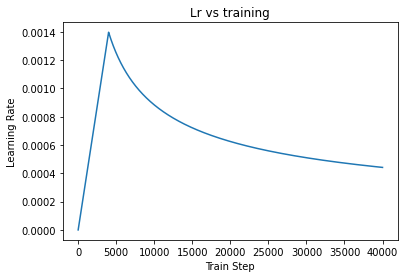

In [ ]:
#Use the Adam optimizer with a custom learning rate scheduler according to the formula
class CustomSchedules(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedules, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedules(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedules(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.title("Lr vs training")
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
#Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_functions(real, pred):
    mask_df = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask_df = tf.cast(mask_df, dtype=loss_.dtype)
    loss_ *= mask_df

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask_df)


def accuracy_functions(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask_df = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask_df, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask_df = tf.cast(mask_df, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask_df)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)
def create_masks(inp, tar):
    ## Encoder padding mask
    enc_padding_mask = create_padding_masks(inp)
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_masks(inp)
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_masks(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_masks(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
#!mkdir training_checkpoints
checkpoint_path = "/content/training_checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_functions(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_functions(tar_real, predictions))

In [ ]:
#English is used as the input language and Hindi is the target language.
acc_g = []
loss_g = []
acc_gg = []
loss_gg= []
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
        if batch % 200 == 0:
            acc_g.append(f'{train_accuracy.result():.4f}')
            loss_g.append(f'{train_loss.result():.4f}')
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
            #print(acc_g,loss_g)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    acc_gg.append(f'{train_accuracy.result():.4f}')
    loss_gg.append(f'{train_loss.result():.4f}')
    print(acc_gg,loss_gg)
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.7438 Accuracy 0.8239


KeyboardInterrupt: ignored

In [ ]:
acc_g = ['0.8130', '0.8132', '0.8136', '0.8140', '0.8144', '0.8147', '0.8151', '0.8155', '0.8159', '0.8217']
loss_g = ['0.8754', '0.8457', '0.8075', '0.7901', '0.8744', '0.7743', '0.7693', '0.8429', '0.7589', '0.7734']

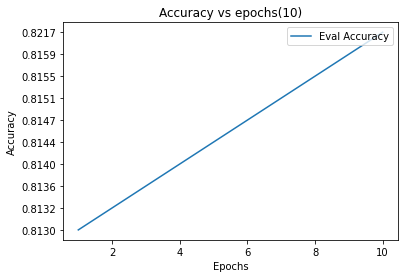

In [ ]:
# importing the required module
#as the epochs increases accuracy increases
import matplotlib.pyplot as plt
# x axis values
x = [1,2,3,4,5,6,7,8,9,10]
# corresponding y axis values
y = acc_g
 
# plotting the points
plt.plot(x,y,label='Eval Accuracy')

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Accuracy')
plt.title('Accuracy vs epochs(10)')
plt.legend(loc="upper right") 
# function to show the plot
plt.show()

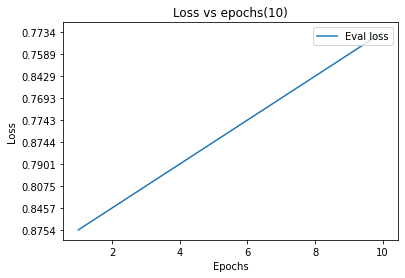

In [ ]:
# importing the required module
#as the epochs increases loss decreases
import matplotlib.pyplot as plt
# x axis values
x = [1,2,3,4,5,6,7,8,9,10]
# corresponding y axis values
y = loss_g
 
# plotting the points
plt.plot(x, y, label='Eval loss')
 
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss')
plt.title('Loss vs epochs(10)')
plt.legend(loc="upper right") 
# function to show the plot
plt.show()

In [ ]:
accu = float(f'{train_accuracy.result():.4f}')
loss_f = float(f'{train_loss.result():.4f}')
print('Accuracy',accu)
print('loss',loss_f)

Accuracy 0.8244
loss 0.7702


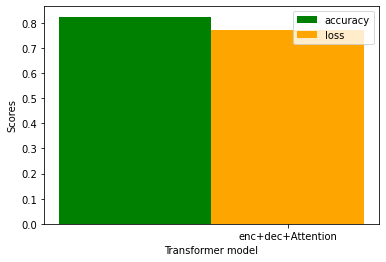

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# create data
x = np.arange(1)
y1 = [accu]
y2 = [loss_f]
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='green')
plt.bar(x, y2, width, color='orange')
plt.xticks(x, ['enc+dec+Attention'])
plt.xlabel("Transformer model")
plt.ylabel("Scores")
plt.legend(["accuracy", "loss"])
plt.show()

In [ ]:
#evaluate the model for realtime input
#Encode the input sentence using the English tokenizer (tokenizers.pt). This is the encoder input.
##The decoder input is initialized to the [START] token.
#Calculate the padding masks and the look ahead masks.
#The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
#The model makes predictions of the next word for each word in the output. 
#Most of these are redundant. Use the predictions from the last word.
#Concatenate the predicted word to the decoder input and pass it to the decoder.
#In this approach, the decoder predicts the next word based on the previous words it predicted.
from nltk.translate.bleu_score import sentence_bleu#to calculate the bleu score
def evaluation(text):
    # inp sentence is portuguese, hence adding the start and end token
    text = eng_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=ENCODER_LEN, padding='post', truncating='post')
    encoder_input = tf.expand_dims(text[0], 0)
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [hind_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        ## predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        ## select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == hind_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate_hindi(eng_text):
    hind_text = evaluation(text=eng_text)[0].numpy()
    a = hind_text
    a1 = len(a)
    hind_text = np.expand_dims(hind_text[1:], 0)
    b = hind_text
    b1 = len(b[0])
    d = a1+b1
    c = list(set(a).intersection(b[0]))
    c1=len(c)
    d1 = (c1/d)
    score = int(d1*100)
    print('Bleu score:', '%3d'%score)
    #print(hind_text)  
    return hind_tokenizer.sequences_to_texts(hind_text)[0]

In [ ]:
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))

In [ ]:
a = 'the war is going in our favor.'
b= translate_hindi(a)
print(b)#how are you doing

Bleu score:  40
यह हमारे सुरक्षा हमारे युद्ध समर्थन को समर्थन देने जा रहा है।


In [ ]:
def translate(sentence):
  hind_text = evaluation(text=sentence)[0].numpy()
  hind_text = np.expand_dims(hind_text[1:], 0)
  return hind_tokenizer.sequences_to_texts(hind_text)[0]


In [ ]:
translate(u'the war is going in our favor.')

'यह हमारे सुरक्षा हमारे युद्ध समर्थन को समर्थन देने जा रहा है।'

In [ ]:
test_df.head(1)

,english_sentence,hindi_sentence
0,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."


In [ ]:
test_df1=test_df.take(np.random.permutation(len(test_df))[:4])

In [ ]:
for index, row in test_df1.iterrows():
    print(row['english_sentence'])
    print(translate_hindi(row['english_sentence']))
    print('\n')

Abu-Yakub of Sijistan maintains in his book , called The disclosing of that which is veiled , that the species are preserved ; that metempsychosis always proceeds in one and the same species , never crossing its limits and passing into another species .
Bleu score:  38
अबू धाबी में प्रतिभाओं की ओर बना रहेगा इस पुस्‍तक को देखते हुए यह पता विश्‍वास का प्रावधान किया गया है कि प्रजातियों की आय बढ़ाने का एक और प्रजातियों की कोई सीमा है कि प्रजातियों पर आवाजाही सुगम और इसलिए स्‍थापित करने में बाधा की सीमा है।


about the world than the chimpanzees.
Bleu score:  48
दुनिया में भी जोश विश्व को अरबों खरबों का अधिकार इस प्रकार प्रदान करती है।


Many people have a prejudice against goat 's milk due to its peculiar flavour .
Bleu score:  45
हर कोई 2 2 समृद्ध अगर उसको बना लिया है तो हमारे दूध अमीरात की ओर बढ़ने संबंधी हेतु दूध उत्पादन क्षमता रोशन करने आते हैं।


and indeed continue to change those identities
Bleu score:  38
पहचान पहचान पहचान नहीं हवाई न कि इनके बदलाव एवं समाधान पर भी जारी रखने जारी 